# Logistic Regression using `theano`

We'll now walk through using gradient descent to solve logistic regression with `theano`. Just as with our linear regression problems, we'll begin by building up a computational graph, and then let `theano` handle the differentiation for us. 

With the automatic differentiation that `theano` offers, we'll still have to specify the details of what derivatives to compute, but will not actually have to take any by hand. This feature will become invaluable as we move towards neural networks with hundreds of thousands of parameters. 

## Computational Graphs for Logistic Regression 

As we code up our forward and backward propagation steps with `theano`, let's keep their visuals around as a reference: 

### Forward Propagation

<img src="../imgs/custom/logistic_comp_graph_condensed_forprop.png" width=300\>

### Backward Propagation

<img src="../imgs/custom/logistic_comp_graph_condensed_backprop.png" width=400\>

### Building a computational graph with `theano`

As previously mentioned, the biggest difference between our `numpy` and `theano` solutions for logistic regression is that we'll be able to use the automatic differentiation that `theano` offers. In order to do so, we'll have to tell `theano` what quantity to take the derivative of and the parameters that it should take the derivative with respect to, but after that it'll handle the rest. 

Let's take a look...

In [1]:
import numpy as np
import theano.tensor as T
import theano
from datasets.general import gen_multiple_logistic
from utils.plotting import plot_errors
%matplotlib inline

In [2]:
def get_theano_graph(): 
    learning_rate = 0.1
    # 1. Define placeholder matrices for inputs. 
    xs, ys = T.dmatrices('xs', 'ys') # returns one or more matrices of type `float64`
    # 2. Define randomly initialized floats for our betas. 
    betas = theano.shared(np.random.random(size=(4, 1)), name='betas')

    # 3. Define the equation that generates predictions. 
    yhats = 1 / (1 + T.numpy.exp(-T.dot(xs, betas)))
    # 4. Define the equation that generates our errors. 
    es = -(ys * np.log(yhats) + (1 - ys) * np.log(1 - yhats))
    # 5. Define the aggregate cost (mean of squared errors)
    E = es.mean()
    # 6. Take advantage of `theanos` automatic differentiation, and use the derivatives
    #    to perform the update step. 
    d_betas = T.grad(E, betas)
    updates = [(betas, betas - learning_rate * d_betas)]
    # 7. Define a function that we can feed inputs to, obtain outputs from, and 
    #    perform updates on our coefficients / train them. 
    train = theano.function(inputs=[xs, ys], outputs=[E, yhats], 
                            updates=updates)
    
    return train

Our solution here for logistic regression is going to look extremely similar to our solution for multiple linear regression (notebook `2c`). The only differences will be in the calculations of the predicted values (`yhats`) and errors (`es`) in steps `3` and `4`. Let's walk through each piece of the code to refresh our memory on how it works...

From a high level, `get_theano_graph` returns a `theano.function` object that performs one iteration of our gradient descent procedure. It performs both forward propagation (steps `1-5`) and backward propagation (step `6`), and in the end [generates a callable function](http://deeplearning.net/software/theano/library/compile/function.html#module-theano.compile.function) that we can later use to perform one iteration of our gradient descent procedure (step `7`).  

In step `6`, we use `T.grad` to take advantage of the automatic differentiation that `theano` offers. With `T.grad`, we pass as the first argument the quantity to take the derivative of and as the second what to take the derivative with respect to. Recall that the `T.grad` function expects a scalar input, which is why we differentiate the mean of the individual binary crossentropy calculations (as opposed to a vector of individual errors). Mathematically, taking the derivative of the mean is the same as taking the mean of the individual derivatives, since the derivative of a sum is equal to the sum of the derivatives. 

The callable function generated in step `7` takes inputs (via the `inputs` argument), runs them through the graph, and returns outputs (specified by the `outputs` argument). This function has the side effect of updating the values of each of the betas in our `betas` shared variable (specified by the `updates` argument), which is ultimately how we learn the values for our coefficients. 

It's important to again note that our `betas` variable is defined as a [shared variable](http://deeplearning.net/software/theano/tutorial/examples.html#using-shared-variables), which tells `theano` that it should **share** the values held in this variable across calls to the function generated in step `7`. As a result, `theano` uses the `betas` variable values from the previous call to our function as the `betas` variable values that it updates in the current call. This ensures that we are continuously updating our `betas` through each call to our function, and over time converging to their true values.

Now, we'll dive into some code that uses this function to learn the true values for our `betas` vector. 

Final Error: 0.00019969970953586627


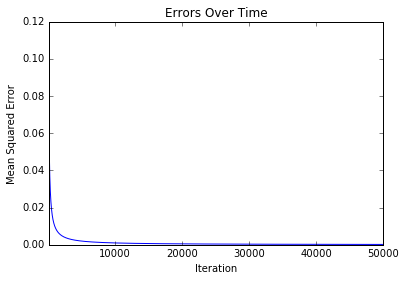

In [3]:
# Randomly generate our betas and number of observations, used to generate 
# fake data to fit. We should have a minimum of 4 obs., since we have 
# 4 coefficients. 
true_betas_array = np.random.randint(2, 10, size=4)
n_obs = np.random.randint(9500, 10500) 

# Generate the data that follows a logistic relationship specified 
# by true_betas_array.
xs, ys = gen_multiple_logistic(true_betas_array, n_obs)
ys = ys > 0.5

theano_linear_graph = get_theano_graph()
binary_crossentropy_lst = []
for _ in range(50000): 
    binary_crossentropy, yhats = theano_linear_graph(xs, ys)
    binary_crossentropy_lst.append(binary_crossentropy)
# Skip the first 100 values because it pulls the y-axis up quite a bit. 
plot_errors(binary_crossentropy_lst, iterations=(100, 50000))
print("Final Error: {}".format(binary_crossentropy_lst[-1]))

As we can see, this implementation is pretty similar to our implementation using `numpy`. The biggest difference is that we call our function `theano_linear_graph` at each iteration of our loop as opposed to having the entire looping process defined within a function. Given that our `theano_linear_graph` by definition performs only **a single** iteration of our gradient descent procedure, this makes sense. 

Overall, we see that we can solve our logistic regression problem using this computational graph that we defined with `theano`. Now, we'll code this up using `tensorflow`.